<a href="https://colab.research.google.com/github/superbunny38/Projects/blob/main/BloodPressureEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') #한글 깨짐 방지

In [ ]:
from tqdm import tnrange, tqdm_notebook

In [ ]:
import argparse
import sys
import time
import copy

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

#from utils import read_ZINC_smiles, smiles_to_onehot, partition, OneHotLogPDataSet
from tqdm import tnrange, tqdm_notebook
import pandas as pd

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/2022/BloodPressure/국민건강보험공단_건강검진정보_20211229.CSV',encoding='cp949')

In [ ]:
data.head()

,기준년도,가입자 일련번호,시도코드,성별코드,연령대 코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),...,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,치석,데이터 공개일자
0,2020,1,36,1,9,165,60,72.1,1.2,1.5,...,1.1,21.0,27.0,21.0,1.0,0.0,0,NaN,NaN,2021-12-29
1,2020,2,27,2,13,150,65,81.0,0.8,0.8,...,0.5,18.0,15.0,15.0,1.0,0.0,0,NaN,NaN,2021-12-29
2,2020,3,11,2,12,155,55,70.0,0.6,0.7,...,0.7,27.0,25.0,7.0,1.0,0.0,0,NaN,NaN,2021-12-29
3,2020,4,31,1,13,160,70,90.8,1.0,1.0,...,1.2,65.0,97.0,72.0,1.0,0.0,1,0.0,0.0,2021-12-29
4,2020,5,41,2,12,155,50,75.2,1.5,1.2,...,0.7,18.0,17.0,14.0,1.0,0.0,0,NaN,NaN,2021-12-29


In [ ]:
data.columns

Index(['기준년도', '가입자 일련번호', '시도코드', '성별코드', '연령대 코드(5세단위)', '신장(5Cm단위)',
       '체중(5Kg 단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기 혈압',
       '이완기 혈압', '식전혈당(공복혈당)', '총 콜레스테롤', '트리글리세라이드', 'HDL 콜레스테롤', 'LDL 콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마 지티피', '흡연상태',
       '음주여부', '구강검진 수검여부', '치아우식증유무', '치석', '데이터 공개일자'],
      dtype='object')

In [ ]:
data.shape

(1000000, 31)

In [ ]:
data.dtypes

기준년도              int64
가입자 일련번호          int64
시도코드              int64
성별코드              int64
연령대 코드(5세단위)      int64
신장(5Cm단위)         int64
체중(5Kg 단위)        int64
허리둘레            float64
시력(좌)           float64
시력(우)           float64
청력(좌)           float64
청력(우)           float64
수축기 혈압          float64
이완기 혈압          float64
식전혈당(공복혈당)      float64
총 콜레스테롤         float64
트리글리세라이드        float64
HDL 콜레스테롤       float64
LDL 콜레스테롤       float64
혈색소             float64
요단백             float64
혈청크레아티닌         float64
(혈청지오티)AST      float64
(혈청지오티)ALT      float64
감마 지티피          float64
흡연상태            float64
음주여부            float64
구강검진 수검여부         int64
치아우식증유무         float64
치석              float64
데이터 공개일자         object
dtype: object

In [ ]:
data.describe()

,기준년도,가입자 일련번호,시도코드,성별코드,연령대 코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),...,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,치석
count,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,999892.000000,999743.000000,999748.000000,...,987859.000000,992398.000000,992399.000000,992398.000000,992397.000000,999657.000000,999804.000000,1000000.000000,331383.00000,331382.000000
mean,2020.0,500000.500000,34.047725,1.489311,11.917757,160.964085,63.060790,82.357094,0.933045,0.935036,...,1.122333,0.851984,27.698337,26.759641,37.778292,1.557421,0.584800,0.331384,0.16859,0.584661
std,0.0,288675.278932,12.443883,0.499886,2.171036,9.197899,12.269907,9.622632,0.637453,0.644911,...,0.493386,0.369630,25.286659,25.835091,51.815871,0.783742,0.492757,0.470711,0.37439,0.589833
min,2020.0,1.000000,11.000000,1.000000,9.000000,130.000000,30.000000,5.800000,0.100000,0.100000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,2020.0,250000.750000,27.000000,1.000000,10.000000,155.000000,55.000000,76.000000,0.700000,0.700000,...,1.000000,0.700000,20.000000,16.000000,16.000000,1.000000,0.000000,0.000000,0.00000,0.000000
50%,2020.0,500000.500000,41.000000,1.000000,12.000000,160.000000,60.000000,82.000000,0.900000,0.900000,...,1.000000,0.800000,24.000000,21.000000,24.000000,1.000000,1.000000,0.000000,0.00000,1.000000
75%,2020.0,750000.250000,44.000000,2.000000,13.000000,170.000000,70.000000,89.000000,1.200000,1.200000,...,1.000000,1.000000,30.000000,31.000000,40.000000,2.000000,1.000000,1.000000,0.00000,1.000000
max,2020.0,1000000.000000,49.000000,2.000000,18.000000,195.000000,135.000000,999.000000,9.900000,9.900000,...,6.000000,95.000000,8712.000000,5990.000000,2630.000000,3.000000,1.000000,1.000000,1.00000,2.000000


# 1. EDA

- 주어진 데이터에 대하여 전처리를 수행합니다.
- 주어진 데이터에 대하여 기계학습을 위한 통찰(Insight)을 제시합니다.
- 추론 가능한 작업, 적합한 기계학습 모델 등

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50756 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54792 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50517 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/bac

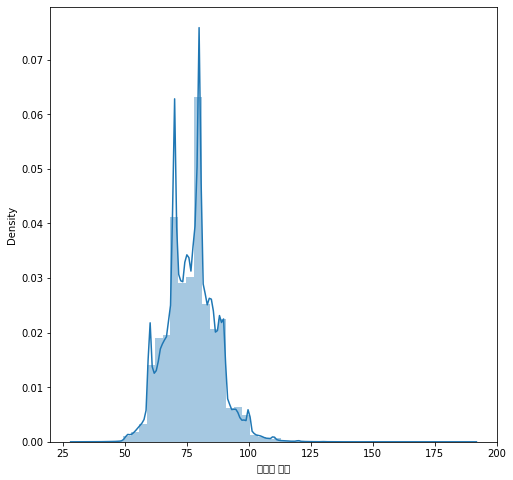

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(data['이완기 혈압'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54792 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50517 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_

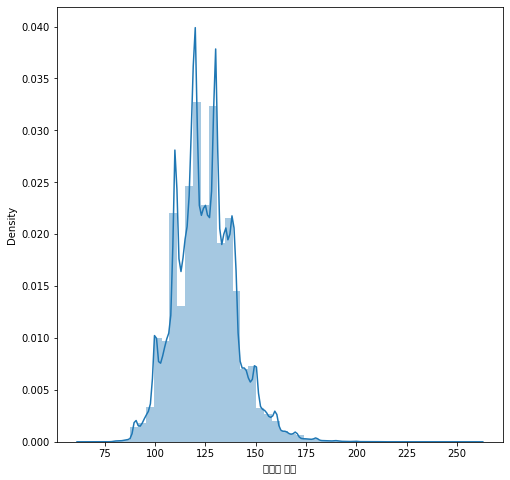

In [ ]:
plt.figure(figsize=(8,8))
sns.distplot(data['수축기 혈압'])

In [ ]:
data.isna().sum()#NA값 확인

기준년도                 0
가입자 일련번호             0
시도코드                 0
성별코드                 0
연령대 코드(5세단위)         0
신장(5Cm단위)            0
체중(5Kg 단위)           0
허리둘레               108
시력(좌)              257
시력(우)              252
청력(좌)              222
청력(우)              230
수축기 혈압            7532
이완기 혈압            7534
식전혈당(공복혈당)        7602
총 콜레스테롤         597694
트리글리세라이드        597678
HDL 콜레스테롤       597685
LDL 콜레스테롤       605529
혈색소               7611
요단백              12141
혈청크레아티닌           7602
(혈청지오티)AST        7601
(혈청지오티)ALT        7602
감마 지티피            7603
흡연상태               343
음주여부               196
구강검진 수검여부            0
치아우식증유무         668617
치석              668618
데이터 공개일자             0
dtype: int64

# 예측에 사용할 데이터 전처리

기준년도, 가입자 일련번호, 시도코드, 데이터 공개일자 제외

In [ ]:
use_df = data.iloc[:,3:-1]
use_df.head()#기준년도, 가입자 일련번호, 시도코드, 데이터 공개일자 제외

,성별코드,연령대 코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기 혈압,...,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,치석
0,1,9,165,60,72.1,1.2,1.5,1.0,1.0,127.0,...,1.0,1.1,21.0,27.0,21.0,1.0,0.0,0,NaN,NaN
1,2,13,150,65,81.0,0.8,0.8,1.0,1.0,110.0,...,1.0,0.5,18.0,15.0,15.0,1.0,0.0,0,NaN,NaN
2,2,12,155,55,70.0,0.6,0.7,1.0,1.0,123.0,...,1.0,0.7,27.0,25.0,7.0,1.0,0.0,0,NaN,NaN
3,1,13,160,70,90.8,1.0,1.0,1.0,2.0,134.0,...,1.0,1.2,65.0,97.0,72.0,1.0,0.0,1,0.0,0.0
4,2,12,155,50,75.2,1.5,1.2,1.0,1.0,144.0,...,1.0,0.7,18.0,17.0,14.0,1.0,0.0,0,NaN,NaN


In [ ]:
df = use_df

## Correlation 시각화

normalize해줘야하나?

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47161 missing from current font.
  font.set_

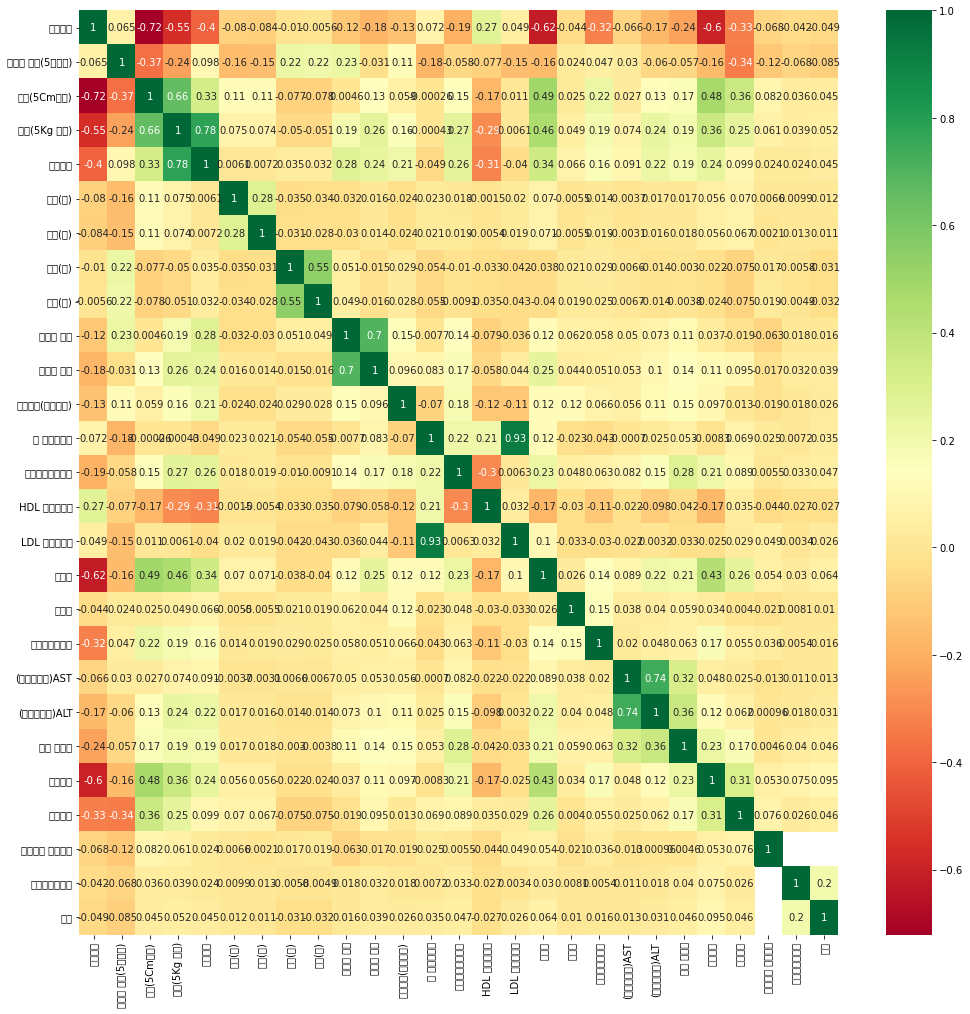

In [ ]:
corrmat = use_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(17,17))
sns.heatmap(use_df[top_corr_features].corr(),annot=True,cmap='RdYlGn')

In [ ]:
abs(corrmat['이완기 혈압']).sort_values()

시력(우)           0.014267
청력(좌)           0.015231
시력(좌)           0.015523
청력(우)           0.015562
구강검진 수검여부       0.017130
연령대 코드(5세단위)    0.030582
치아우식증유무         0.032381
치석              0.038925
요단백             0.043905
LDL 콜레스테롤       0.044278
혈청크레아티닌         0.050919
(혈청지오티)AST      0.052773
HDL 콜레스테롤       0.057869
총 콜레스테롤         0.083263
음주여부            0.095305
식전혈당(공복혈당)      0.096442
(혈청지오티)ALT      0.103708
흡연상태            0.110998
신장(5Cm단위)       0.133519
감마 지티피          0.140967
트리글리세라이드        0.168525
성별코드            0.176693
허리둘레            0.242307
혈색소             0.249669
체중(5Kg 단위)      0.257129
수축기 혈압          0.700120
이완기 혈압          1.000000
Name: 이완기 혈압, dtype: float64

In [ ]:
abs(corrmat['수축기 혈압']).sort_values()

신장(5Cm단위)       0.004569
총 콜레스테롤         0.007708
치석              0.016441
치아우식증유무         0.018284
음주여부            0.019150
시력(우)           0.030420
시력(좌)           0.031905
LDL 콜레스테롤       0.036289
흡연상태            0.037068
청력(우)           0.049384
(혈청지오티)AST      0.049696
청력(좌)           0.050966
혈청크레아티닌         0.057696
요단백             0.061521
구강검진 수검여부       0.063256
(혈청지오티)ALT      0.073266
HDL 콜레스테롤       0.079045
감마 지티피          0.111280
성별코드            0.116329
혈색소             0.121544
트리글리세라이드        0.136339
식전혈당(공복혈당)      0.149219
체중(5Kg 단위)      0.191802
연령대 코드(5세단위)    0.229686
허리둘레            0.275676
이완기 혈압          0.700120
수축기 혈압          1.000000
Name: 수축기 혈압, dtype: float64

**Insight**: Correlation을 통해 확인한 결과, 수축기 혈압이나 이완기 혈압과 아주 상관관계가 높은 variable은 없었다. 그럼에도 허리둘레와 체중이 중요한 변수일 것임을 알 수 있었다.

의료 데이터에서는 데이터를 변형하는 것을 조심해야 한다고 생각했기에, 원본이 가지고 있는 정보를 유지하기 위해 결측값이 있는 data sample은 모두 사용하지 않았다.

In [ ]:
data.shape#원본 데이터 사이즈

(1000000, 31)

In [ ]:
use_df.dropna().shape#결측치 제거 데이터 사이즈

(125537, 27)

In [ ]:
use_df = use_df.dropna()

Changing the values of categorical columns

In [ ]:
use_df.columns

Index(['성별코드', '연령대 코드(5세단위)', '신장(5Cm단위)', '체중(5Kg 단위)', '허리둘레', '시력(좌)',
       '시력(우)', '청력(좌)', '청력(우)', '수축기 혈압', '이완기 혈압', '식전혈당(공복혈당)', '총 콜레스테롤',
       '트리글리세라이드', 'HDL 콜레스테롤', 'LDL 콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
       '(혈청지오티)AST', '(혈청지오티)ALT', '감마 지티피', '흡연상태', '음주여부', '구강검진 수검여부',
       '치아우식증유무', '치석'],
      dtype='object')

changed categorical columns: 성별코드, 흡연상태, '음주여부', '구강검진 수검여부',
       '치아우식증유무', '치석'

In [ ]:
use_df['성별코드'][use_df['성별코드'] == 2] = 'female'#성별 : 1(남자), 2(여자)
use_df['성별코드'][use_df['성별코드'] == 1] = 'male'
use_df['흡연상태'][use_df['흡연상태'] == 3] = 'smoking'
use_df['흡연상태'][use_df['흡연상태'] == 2] = 'smoked'
use_df['흡연상태'][use_df['흡연상태'] == 1] = 'never tried'
use_df['음주여부'][use_df['음주여부'] == 1] = 'yes'
use_df['음주여부'][use_df['음주여부'] == 0] = 'no'
use_df['구강검진 수검여부'][use_df['구강검진 수검여부'] == 1] = 'yes'
use_df['구강검진 수검여부'][use_df['구강검진 수검여부'] == 0] = 'no'
use_df['치아우식증유무'][use_df['치아우식증유무'] == 1] = 'yes'
use_df['치아우식증유무'][use_df['치아우식증유무'] == 0] = 'no'
use_df['치석'][use_df['치석'] == 1] = 'yes'
use_df['치석'][use_df['치석'] == 0] = 'no'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/pytho

Label the target variable so that we can visualize relationship between the input variables and target variable

In [ ]:
use_df['target'] = use_df['이완기 혈압']
use_df['target'][(use_df['이완기 혈압'] <= 80) & (use_df['수축기 혈압']<=120)] = 'stable'#안정혈압상태: 이완기 혈압 80 이하 그리고 수축기 혈압 120 이하인 데이터
use_df['target'][(use_df['이완기 혈압'] >= 80) & (use_df['수축기 혈압']>=130)] = 'high'#고혈압상태: 이완기 혈압 90 이상 또는 수축기 혈압 130 이상인 데이터
use_df['target'][(use_df['target'] != 'stable') & (use_df['target']!='high')] = 'unstable'#불안정혈압상태: 나머지 모든 데이터

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

성별과 혈압 상태의 관계

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backe

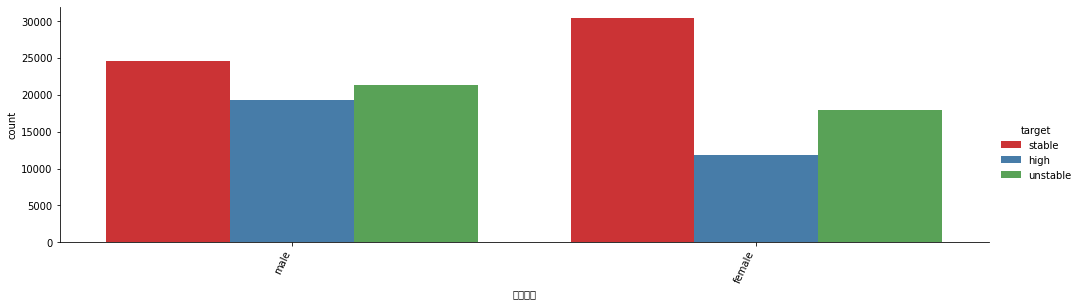

In [ ]:
chart = sns.catplot(
    data=use_df,
    x='성별코드',hue='target',
    kind='count',
    palette='Set1',
    aspect=3.5,
    height=4
)
for axes in chart.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')

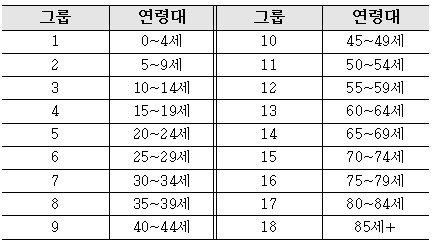

In [ ]:
np.unique(use_df['연령대 코드(5세단위)'])

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47161 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49464 missing from current font.
  font.set_

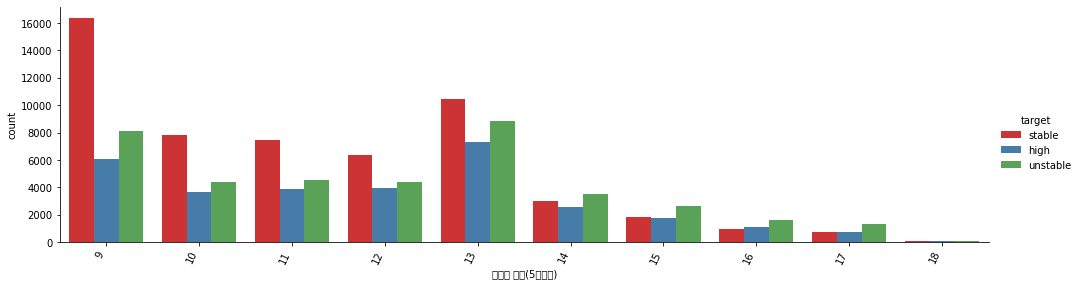

In [ ]:
chart = sns.catplot(
    data=use_df,
    x='연령대 코드(5세단위)',hue='target',
    kind='count',
    palette='Set1',
    aspect=3.5,
    height=4
)
for axes in chart.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')

In [ ]:
use_df.columns

Index(['성별코드', '연령대 코드(5세단위)', '신장(5Cm단위)', '체중(5Kg 단위)', '허리둘레', '시력(좌)',
       '시력(우)', '청력(좌)', '청력(우)', '수축기 혈압', '이완기 혈압', '식전혈당(공복혈당)', '총 콜레스테롤',
       '트리글리세라이드', 'HDL 콜레스테롤', 'LDL 콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
       '(혈청지오티)AST', '(혈청지오티)ALT', '감마 지티피', '흡연상태', '음주여부', '구강검진 수검여부',
       '치아우식증유무', '치석', 'target'],
      dtype='object')

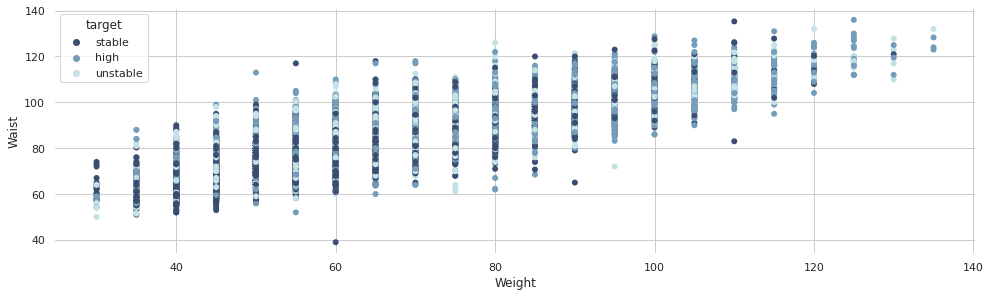

In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(16.5, 4.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='체중(5Kg 단위)', y='허리둘레',hue='target',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=use_df, ax=ax)
plt.xlabel('Weight')
plt.ylabel('Waist')
plt.show()

# 2. 라벨링

- 주어진 데이터에서 혈압측정값(이완기 혈압, 수축기 혈압)들을 분리합니다.
- 분리한 혈압측정값들로부터 혈압상태 항목을 생성합니다. (3개의 상태)
  - 안정혈압상태: 이완기 혈압 80 이하 그리고 수축기 혈압 120 이하인 데이터
  - 고혈압상태: 이완기 혈압 90 이상 또는 수축기 혈압 130 이상인 데이터
  - 불안정혈압상태: 나머지 모든 데이터

- 생성한 혈압상태값을 시각화를 통하여 검증합니다.

In [ ]:
use_df.head()

,성별코드,연령대 코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기 혈압,...,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,치석,target
6,male,9,165,80,93.0,0.8,0.7,1.0,2.0,112.0,...,0.7,18.0,20.0,35.0,smoking,yes,yes,no,yes,stable
16,male,11,160,65,90.0,0.6,0.6,1.0,1.0,138.0,...,1.0,29.0,54.0,24.0,never tried,yes,yes,no,yes,high
21,female,11,155,50,65.9,0.7,1.0,1.0,1.0,114.0,...,0.8,24.0,14.0,12.0,never tried,no,yes,no,no,stable
27,male,17,155,60,82.0,0.5,0.7,1.0,1.0,139.0,...,1.4,33.0,22.0,29.0,never tried,yes,yes,no,no,high
47,male,16,165,65,94.0,1.5,0.6,2.0,2.0,110.0,...,1.0,28.0,20.0,43.0,never tried,yes,yes,no,no,stable


In [ ]:
np.unique(use_df['target'])

array(['high', 'stable', 'unstable'], dtype=object)

# 3. 분류 모델
- 혈압측정값이 제외된 나머지 데이터와 본인이 직접 생성한 혈압상태값을 사용하여,
혈압상태를 분류하는 지도학습 모델을 설계합니다.
  - 기존에 공개된 라이브러리 형태의 기계학습 모델은 사용 불가합니다.
  - Tensorflow 또는 Pytorch를 사용하여 심층신경망 모델을 직접 설계합니다.

- 설계한 모델의 성능을 확인하고 개선점을 찾아서 성능을 개선합니다.



# GCN

GCN code reference: https://github.com/heartcored98/Standalone-DeepLearning/blob/master/Lec9/Lab11_logP_Prediction_with_GCN.ipynb


## Data Preprocessing to fit GCN

In [ ]:
#encode target variable
import sklearn.preprocessing as preprocessing
labelencoder=preprocessing.LabelEncoder()
label=labelencoder.fit(['high','stable','unstable']).transform(use_df['target'])

In [ ]:
label[:5]

array([1, 0, 1, 0, 1])

In [ ]:
x_df = use_df.drop('target',axis = 1)
x_df.head()

,성별코드,연령대 코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기 혈압,...,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,치석
6,male,9,165,80,93.0,0.8,0.7,1.0,2.0,112.0,...,1.0,0.7,18.0,20.0,35.0,smoking,yes,yes,no,yes
16,male,11,160,65,90.0,0.6,0.6,1.0,1.0,138.0,...,1.0,1.0,29.0,54.0,24.0,never tried,yes,yes,no,yes
21,female,11,155,50,65.9,0.7,1.0,1.0,1.0,114.0,...,1.0,0.8,24.0,14.0,12.0,never tried,no,yes,no,no
27,male,17,155,60,82.0,0.5,0.7,1.0,1.0,139.0,...,1.0,1.4,33.0,22.0,29.0,never tried,yes,yes,no,no
47,male,16,165,65,94.0,1.5,0.6,2.0,2.0,110.0,...,1.0,1.0,28.0,20.0,43.0,never tried,yes,yes,no,no


In [ ]:
original = data
data = data.dropna()

In [ ]:
use_df.dtypes

성별코드             object
연령대 코드(5세단위)      int64
신장(5Cm단위)         int64
체중(5Kg 단위)        int64
허리둘레            float64
시력(좌)           float64
시력(우)           float64
청력(좌)           float64
청력(우)           float64
수축기 혈압          float64
이완기 혈압          float64
식전혈당(공복혈당)      float64
총 콜레스테롤         float64
트리글리세라이드        float64
HDL 콜레스테롤       float64
LDL 콜레스테롤       float64
혈색소             float64
요단백             float64
혈청크레아티닌         float64
(혈청지오티)AST      float64
(혈청지오티)ALT      float64
감마 지티피          float64
흡연상태             object
음주여부             object
구강검진 수검여부        object
치아우식증유무          object
치석               object
target           object
dtype: object

In [ ]:
x_df = use_df
x_df['성별코드']= df['성별코드']
x_df['흡연상태'] = df['흡연상태']
x_df['음주여부'] = df['음주여부']
x_df['구강검진 수검여부']=  df['구강검진 수검여부']
x_df['치아우식증유무'] = df['치아우식증유무']
x_df['치석'] = df['치석']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
y=x_df['target']
x_df = x_df.drop('target', axis = 1)

x_df.head()

,성별코드,연령대 코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기 혈압,...,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,치석
6,1,9,165,80,93.0,0.8,0.7,1.0,2.0,112.0,...,1.0,0.7,18.0,20.0,35.0,3.0,1.0,1,0.0,1.0
16,1,11,160,65,90.0,0.6,0.6,1.0,1.0,138.0,...,1.0,1.0,29.0,54.0,24.0,1.0,1.0,1,0.0,1.0
21,2,11,155,50,65.9,0.7,1.0,1.0,1.0,114.0,...,1.0,0.8,24.0,14.0,12.0,1.0,0.0,1,0.0,0.0
27,1,17,155,60,82.0,0.5,0.7,1.0,1.0,139.0,...,1.0,1.4,33.0,22.0,29.0,1.0,1.0,1,0.0,0.0
47,1,16,165,65,94.0,1.5,0.6,2.0,2.0,110.0,...,1.0,1.0,28.0,20.0,43.0,1.0,1.0,1,0.0,0.0


In [ ]:
x_df.shape

(125537, 27)

In [ ]:
tmp_df = x_df
tmp_df['target'] = label
corrmat = tmp_df.corr()

In [ ]:
abs(corrmat['target']).sort_values()

혈청크레아티닌         0.010077
HDL 콜레스테롤       0.010245
시력(우)           0.011516
시력(좌)           0.012763
치석              0.013721
청력(좌)           0.014895
청력(우)           0.015131
요단백             0.016310
치아우식증유무         0.017815
LDL 콜레스테롤       0.020839
(혈청지오티)AST      0.021784
흡연상태            0.029057
연령대 코드(5세단위)    0.029277
식전혈당(공복혈당)      0.030323
음주여부            0.033433
총 콜레스테롤         0.035439
신장(5Cm단위)       0.036554
(혈청지오티)ALT      0.038997
성별코드            0.047497
감마 지티피          0.054327
트리글리세라이드        0.060713
허리둘레            0.067452
혈색소             0.075856
체중(5Kg 단위)      0.080127
수축기 혈압          0.261221
이완기 혈압          0.350389
target          1.000000
구강검진 수검여부            NaN
Name: target, dtype: float64

### PCA to reduce feature

근데 test set에는 transform만 해야함

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
X_data = pca.fit_transform(x_df)

In [ ]:
pca.explained_variance_ratio_

array([0.43626146, 0.24182622, 0.16113987, 0.04517628, 0.04023518,
       0.02504418, 0.02036541, 0.01359636, 0.00653294, 0.0046205 ])

In [ ]:
X_data = X_data[:,:8]

In [ ]:
X_data.shape

(125537, 8)

### Arg parser

In [ ]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

### Build Adj matrix & Graph

In [ ]:
#construct graph & adjacency matrix
from sklearn.neighbors import kneighbors_graph
X = X_data
n = X_data.shape[1] + 3
A = kneighbors_graph(X_data, n_neighbors=n, metric="euclidean")

In [ ]:
X = pd.DataFrame(X).to_numpy()

In [ ]:
import networkx as nx
g = nx.Graph(A)#embed in graph

In [ ]:
adj = nx.adjacency_matrix(g)#adjacency matrix
n_nodes = adj.shape[0]

In [ ]:
adj.shape

(125537, 125537)

In [ ]:
nb_classes = len(set(label))
targets = np.array([label], dtype=np.int32).reshape(-1)
one_hot_targets = np.eye(nb_classes)[targets]

In [ ]:
import sparse as us
import scipy.sparse
feat_x = X
feat_x_tuple = us.sparse_to_tuple(scipy.sparse.coo_matrix(feat_x))

ModuleNotFoundError: ignored

In [ ]:
feat_x_list = np.array(feat_x_tuple)

In [ ]:
feat_x_list.shape

### Split data

In [ ]:
class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_label):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_label = list_label

    def __len__(self):
        return len(self.list_feature)

    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_label[index]

In [ ]:
def partition(list_feature, list_adj, list_logP, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)

    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    logP_train = list_logP[:num_train]
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    logP_val = list_logP[num_train:num_train + num_val]
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    logP_test = list_logP[num_total - num_test:]
        
    train_set = GCNDataset(feature_train, adj_train, logP_train)
    val_set = GCNDataset(feature_val, adj_val, logP_val)
    test_set = GCNDataset(feature_test, adj_test, logP_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [ ]:
dict_partition = partition(feat_x_list, adj, one_hot_targets, args)

In [ ]:
class SkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x
        return out

In [ ]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out
            
    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)

In [ ]:
class Attention(nn.Module):
    
    def __init__(self, in_dim, output_dim, num_head):
        super(Attention, self).__init__()
        
        self.num_head = num_head
        self.atn_dim = output_dim // num_head
        
        self.linears = nn.ModuleList()
        self.corelations = nn.ParameterList()
        for i in range(self.num_head):
            self.linears.append(nn.Linear(in_dim, self.atn_dim))
            corelation = torch.FloatTensor(self.atn_dim, self.atn_dim)
            nn.init.xavier_uniform_(corelation)
            self.corelations.append(nn.Parameter(corelation))
            
        self.tanh = nn.Tanh()
        
    def forward(self, x, adj):
        heads = list()
        for i in range(self.num_head):
            x_transformed = self.linears[i](x)
            alpha = self.attention_matrix(x_transformed, self.corelations[i], adj)
            x_head = torch.matmul(alpha, x_transformed)
            heads.append(x_head)
        output = torch.cat(heads, dim=2)
        return output
            
    def attention_matrix(self, x_transformed, corelation, adj):
        x = torch.einsum('akj,ij->aki', (x_transformed, corelation))
        alpha = torch.matmul(x, torch.transpose(x_transformed, 1, 2))
        alpha = torch.mul(alpha, adj)
        alpha = self.tanh(alpha)
        return alpha

In [ ]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_dim, out_dim, n_atom, act=None, bn=False, atn=False, num_head=1, dropout=0):
        super(GCNLayer, self).__init__()
        
        self.use_bn = bn
        self.use_atn = atn
        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.bn = nn.BatchNorm1d(n_atom)
        self.attention = Attention(out_dim, out_dim, num_head)
        self.activation = act
        self.dropout_rate = dropout
        self.dropout = nn.Dropout2d(self.dropout_rate)
        
    def forward(self, x, adj):
        out = self.linear(x)
        if self.use_atn:
            out = self.attention(out, adj)
        else:
            out = torch.matmul(adj, out)
        if self.use_bn:
            out = self.bn(out)
        if self.activation != None:
            out = self.activation(out)
        if self.dropout_rate > 0:
            out = self.dropout(out)
        return out, adj

In [ ]:
class GCNBlock(nn.Module):
    
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, atn=True, num_head=1, sc='gsc', dropout=0):
        super(GCNBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GCNLayer(in_dim if i==0 else hidden_dim,
                                        out_dim if i==n_layer-1 else hidden_dim,
                                        n_atom,
                                        nn.ReLU() if i!=n_layer-1 else None,
                                        bn,
                                        atn,
                                        num_head,
                                        dropout))
        self.relu = nn.ReLU()
        if sc=='gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc=='sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc=='no':
            self.sc = None
        else:
            assert False, "Wrong sc type."
        
    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if self.sc != None:
            out = self.sc(residual, out)
        out = self.relu(out)
        return out, adj

In [ ]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [ ]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [ ]:
class GCNNet(nn.Module):
    
    def __init__(self, args):
        super(GCNNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GCNBlock(args.n_layer,
                                        args.in_dim if i==0 else args.hidden_dim,
                                        args.hidden_dim,
                                        args.hidden_dim,
                                        args.n_atom,
                                        args.bn,
                                        args.atn,
                                        args.num_head,
                                        args.sc,
                                        args.dropout))
        self.readout = ReadOut(args.hidden_dim, 
                               args.pred_dim1,
                               act=nn.ReLU())
        self.pred1 = Predictor(args.pred_dim1,
                               args.pred_dim2,
                               act=nn.ReLU())
        self.pred2 = Predictor(args.pred_dim2,
                               args.pred_dim3,
                               act=nn.Tanh())
        self.pred3 = Predictor(args.pred_dim3,
                               args.out_dim)
        
    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i==0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out

## Functions for procedure

In [ ]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    epoch_train_loss = 0
    total = 0
    correct = 0
    for i, batch in enumerate(data_train):
        list_feature = torch.tensor(batch[0]).to(device).float()
        list_adj = torch.tensor(batch[1]).to(device).float()
        list_logP = torch.tensor(batch[2]).to(device).float()
        list_logP = list_logP.view(-1,1)
        
        model.train()
        optimizer.zero_grad()
        list_pred_logP = model(list_feature, list_adj)
        list_pred_logP.require_grad = False
        
        train_loss = criterion(list_pred_logP, list_logP)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
        _, predicted = torch.max(list_pred_logP.data, 1)
        total += labels.size(0)
        correct += (predicted == list_logP).sum().item()
        bar.update(len(list_feature))

    epoch_train_loss /= len(data_train)
    epoch_train_acc = correct/total
    
    return model, epoch_train_loss, epoch_train_acc

In [ ]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_logP = torch.tensor(batch[2]).to(device).float()
            list_logP = list_logP.view(-1,1)

            model.eval()
            list_pred_logP = model(list_feature, list_adj)
            list_pred_logP.require_grad = False
            val_loss = criterion(list_pred_logP, list_logP)
            epoch_val_loss += val_loss.item()
            _, predicted = torch.max(list_pred_logP.data, 1)
            total += labels.size(0)
            correct += (predicted == list_logP).sum().item()
            bar.update(len(list_feature))

    epoch_val_loss /= len(data_val)
    epoch_train_acc = correct/total

    return model, epoch_val_loss, epoch_train_acc

In [ ]:
def test(model, device, data_test, args):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        logP_total = list()
        pred_logP_total = list()
        for i, batch in enumerate(data_test):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_logP = torch.tensor(batch[2]).to(device).float()
            logP_total += list_logP.tolist()
            list_logP = list_logP.view(-1,1)

            list_pred_logP = model(list_feature, list_adj)
            pred_logP_total += list_pred_logP.view(-1).tolist()

            _, predicted = torch.max(list_pred_logP.data, 1)
            total += labels.size(0)
            correct += (predicted == list_logP).sum().item()

        mae = mean_absolute_error(logP_total, pred_logP_total)
        std = np.std(np.array(logP_total)-np.array(pred_logP_total))
    epoch_train_acc = correct/total    
    return mae, std, logP_total, pred_logP_total, epoch_train_acc

In [ ]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()
    
    model = GCNNet(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()

    data_train = DataLoader(dict_partition['train'], 
                            batch_size=args.batch_size,
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition['val'],
                          batch_size=args.batch_size,
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):
        scheduler.step()
        model, train_loss, train_acc = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        print(f"train loss: {train_loss}, train_acc: {train_acc}")
        model, val_loss, val_acc = validate(model, device, criterion, data_val, bar, args)
        print(f"validation loss: {val_loss}, validation_acc: {val_acc}")
        list_val_loss.append(val_loss)

    data_test = DataLoader(dict_partition['test'],
                           batch_size=args.batch_size,
                           shuffle=args.shuffle)

    mae, std, logP_total, pred_logP_total,test_acc = test(model, device, data_test, args)
    print(f"Final Test acc: {test_acc}")
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.logP_total = logP_total
    args.pred_logP_total = pred_logP_total
    args.mae = mae
    args.std = std
    args.time_required = time_required
    
    return args

In [ ]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)

In [ ]:
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)

In [ ]:
def plot_loss(df_result, var1, var2, ylim):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', ylim=ylim, label='Train Loss')
    g.map(plot, 'list_val_loss', ylim=ylim, color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [ ]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'logP_total', 'pred_logP_total')
    g.map(identity, 'logP_total', 'logP_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()

In [ ]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 100
args.n_block = 3
args.n_layer = 1
args.n_atom = 50
args.in_dim = 58
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = 1
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 16
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Results

In [ ]:
list_lr = [0.01, 0.001, 0.0001, 0.00001]
list_n_block = [1, 2, 3]
#list_lr = [0.001]
#list_n_block = [2]
var1 = "lr"
var2 = "n_block"

dict_result = dict()
n_iter = len(list_n_block)*len(list_lr)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for n_block in list_n_block:
        args.lr = lr
        args.n_block = n_block
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(n_block)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('lr vs n_block 50000.JSON', orient='table')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/2400 [00:00<?, ?it/s]

ValueError: ignored

# Simple NN

In [ ]:
from sklearn.utils import shuffle
tmp_data = pd.DataFrame(X_data, columns = np.arange(8))
tmp_data['target'] = label
shuffled = shuffle(tmp_data)

In [ ]:
shuffled = shuffled.reset_index(drop = True)

In [ ]:
train_idx = int(np.ceil(shuffled.shape[0]*0.8))

In [ ]:
shuffled.shape

(125537, 9)

In [ ]:
train_idx

100430

In [ ]:
shuffled.head()

,0,1,2,3,4,5,6,7,target
0,52.020717,-38.898163,-43.932260,-3.507984,5.342322,2.850853,-6.953900,21.401480,2
1,29.619708,-64.441093,-30.869745,-0.229089,-12.662758,-4.056049,-7.351868,5.290719,0
2,-4.009063,-52.910330,-2.321837,33.097850,36.104732,-2.291838,21.532802,-10.813841,1
3,-30.839969,-5.476235,-14.293298,0.349626,-9.368538,6.185966,-30.601804,2.202498,0
4,284.196015,-57.695505,110.038749,-22.192018,20.421368,-6.298616,4.896295,-18.618956,2


In [ ]:
train_df = shuffled[:train_idx]
test_df = shuffled[train_idx:]

In [ ]:
train_df.head()

,0,1,2,3,4,5,6,7,target
0,52.020717,-38.898163,-43.932260,-3.507984,5.342322,2.850853,-6.953900,21.401480,2
1,29.619708,-64.441093,-30.869745,-0.229089,-12.662758,-4.056049,-7.351868,5.290719,0
2,-4.009063,-52.910330,-2.321837,33.097850,36.104732,-2.291838,21.532802,-10.813841,1
3,-30.839969,-5.476235,-14.293298,0.349626,-9.368538,6.185966,-30.601804,2.202498,0
4,284.196015,-57.695505,110.038749,-22.192018,20.421368,-6.298616,4.896295,-18.618956,2


In [ ]:
import torch.utils.data as data_utils
batch_size = 50
# targets.type(torch.LongTensor)
train_target = torch.tensor(train_df['target'].values.astype(np.float32))
train = torch.tensor(train_df.drop('target', axis = 1).values.astype(np.float32)) 
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [ ]:
test_target = torch.tensor(test_df['target'].values.astype(np.float32))
test = torch.tensor(test_df.drop('target', axis = 1).values.astype(np.float32)) 
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [ ]:
import torch as T
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hid1 = T.nn.Linear(8, 20)  # 6-(10-10)-3
    self.hid2 = T.nn.Linear(20, 10)
    self.oupt = T.nn.Linear(10, 3)

    T.nn.init.xavier_uniform_(self.hid1.weight)
    T.nn.init.zeros_(self.hid1.bias)
    T.nn.init.xavier_uniform_(self.hid2.weight)
    T.nn.init.zeros_(self.hid2.bias)
    T.nn.init.xavier_uniform_(self.oupt.weight)
    T.nn.init.zeros_(self.oupt.bias)

  def forward(self, x):
    z = T.tanh(self.hid1(x))
    z = T.tanh(self.hid2(z))
    z = self.oupt(z)  # no softmax: CrossEntropyLoss() 
    return z

In [ ]:
criterion = nn.CrossEntropyLoss()
model = Net()

In [ ]:
num_epochs = 25

In [ ]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01)

In [ ]:
n_iterations = len(train_tensor)/batch_size

In [ ]:
device = torch.device("cuda")

In [ ]:
model.to(device)
model.train()

Net(
  (hid1): Linear(in_features=8, out_features=20, bias=True)
  (hid2): Linear(in_features=20, out_features=10, bias=True)
  (oupt): Linear(in_features=10, out_features=3, bias=True)
)

### Train

In [ ]:
for epoch in range(num_epochs):
  running_loss = 0.0
  total = 0
  correct = 0
  running_loss = 0
  freq = 0
  for i, data in enumerate(train_loader):
    freq +=1
    inputs, labels = data
    labels = labels.type(torch.LongTensor)
    inputs, labels = inputs.to(device),labels.to(device)
    #print(inputs.is_cuda, labels.is_cuda)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    #print("outputs:",outputs)
    #print("predicted:",predicted)
    #print("labels: ",labels)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss += loss.item()
    
  print(f'Epoch {epoch + 1} Train Acc:{correct/total}, Loss = {running_loss/freq}')

Epoch 1 Train Acc:0.8430150353480036, Loss = 0.3575563200259458
Epoch 2 Train Acc:0.8419695310166285, Loss = 0.35573553458976176
Epoch 3 Train Acc:0.8427661057452952, Loss = 0.356697304241986
Epoch 4 Train Acc:0.8417703873344619, Loss = 0.35678369401698684
Epoch 5 Train Acc:0.8397988648810116, Loss = 0.35811528053195874
Epoch 6 Train Acc:0.8406053967937868, Loss = 0.35809305201958164
Epoch 7 Train Acc:0.8434531514487703, Loss = 0.35849632079503974
Epoch 8 Train Acc:0.8424773474061535, Loss = 0.3597456282973586
Epoch 9 Train Acc:0.8427163198247536, Loss = 0.35713912218052574
Epoch 10 Train Acc:0.8410932988150951, Loss = 0.35488949689389226
Epoch 11 Train Acc:0.8431046500049786, Loss = 0.35253119106729447
Epoch 12 Train Acc:0.8438116100766703, Loss = 0.35312088500317085
Epoch 13 Train Acc:0.8430946928208702, Loss = 0.35218136252129834
Epoch 14 Train Acc:0.8409738126057951, Loss = 0.3537044606364859
Epoch 15 Train Acc:0.83998805137907, Loss = 0.35527317125800834
Epoch 16 Train Acc:0.84502

### Test

In [ ]:
total=0
correct = 0
model.eval()
for i, data in enumerate(test_loader):
    inputs, labels = data
    labels = labels.type(torch.LongTensor)
    inputs, labels = inputs.to(device),labels.to(device)
    #print(inputs.is_cuda, labels.is_cuda)
    output = model(inputs)
    _, predicted = torch.max(output.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
acc = 100 * correct / total
print(f'Val Accuracy: {acc:.2f}')

Val Accuracy: 84.99


# CNN

## [Deepinsight](https://github.com/alok-ai-lab/pyDeepInsight) to transform non-image data to image-shaped

In [ ]:
#!python3 -m pip -q install git+https://github.com/alok-ai-lab/pyDeepInsight.git#egg=pyDeepInsight

In [ ]:
!pip show pyDeepInsight 

Name: pyDeepInsight
Version: 0.1.1
Summary: A methodology to transform a non-image data to an image for convolution neural network architecture
Home-page: https://github.com/alok-ai-lab/pyDeepInsight
Author: Keith A. Boroevich
Author-email: kaboroevich@gmail.com
License: GPLv3
Location: /usr/local/lib/python3.7/dist-packages
Requires: pandas, torch, scikit-learn
Required-by: 


In [ ]:
#!pip install pytorch-gradcam

In [ ]:
#!pip install grad-cam

In [ ]:
#!pip install torchcam

In [ ]:
from pyDeepInsight import ImageTransformer, LogScaler

## Preprocess data with deepinsight

In [ ]:
x_df.head()

,성별코드,연령대 코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기 혈압,...,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,치석,target
6,1,9,165,80,93.0,0.8,0.7,1.0,2.0,112.0,...,0.7,18.0,20.0,35.0,3.0,1.0,1,0.0,1.0,1
16,1,11,160,65,90.0,0.6,0.6,1.0,1.0,138.0,...,1.0,29.0,54.0,24.0,1.0,1.0,1,0.0,1.0,0
21,2,11,155,50,65.9,0.7,1.0,1.0,1.0,114.0,...,0.8,24.0,14.0,12.0,1.0,0.0,1,0.0,0.0,1
27,1,17,155,60,82.0,0.5,0.7,1.0,1.0,139.0,...,1.4,33.0,22.0,29.0,1.0,1.0,1,0.0,0.0,0
47,1,16,165,65,94.0,1.5,0.6,2.0,2.0,110.0,...,1.0,28.0,20.0,43.0,1.0,1.0,1,0.0,0.0,1


In [ ]:
from sklearn.model_selection import train_test_split
X = x_df.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23, stratify=y)

### Normalize data using LogScaler and encode classes

In [ ]:
ln = LogScaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size

### Create t-SNE object

In [ ]:
from sklearn.manifold import TSNE
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    square_distances=True,
    n_jobs=-1
)

### Initialize image transformer.

In [ ]:
pixel_size = (227,227)
it = ImageTransformer(
    feature_extractor=reducer, 
    pixels=pixel_size)

In [ ]:
X_train_norm.shape

(100429, 28)

In [ ]:
y_train_enc.shape

(100429,)

In [ ]:
100429/7

14347.0

In [ ]:
start = 0
mul = 7
x_train_splits = []
for i in range(int(y_train_enc.shape[0]/mul)):
  x_train_splits.append(X_train_norm[start:start+mul,:])
  print(f"{start}:{start+mul}")
  start = start+mul

In [ ]:
X_test_norm.shape

(25108, 28)

In [ ]:
25108/6277

4.0

In [ ]:
start = 0
mul = 4
x_test_splits = []
for i in range(int(X_test_norm.shape[0]/mul)):
  x_test_splits.append(X_test_norm[start:start+mul,:])
  print(f"{start}:{start+mul}")
  start = start+mul

### Train image transformer on training data and transform training and testing sets. 

Values should be between 0 and 1.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


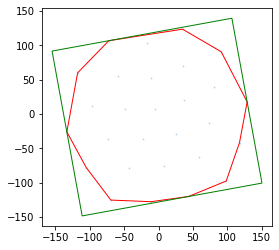

In [ ]:
it.fit(X_train, y=y_train, plot=True)

자꾸 RAM 터짐

In [ ]:
from tqdm import tqdm
import time
X_train_img = []
for img in tqdm(x_train_splits, desc = "x_train_splits",mininterval = 0.01):
  X_train_img.append(it.transform(img))

x_train_splits:   9%|▉         | 1282/14347 [00:27<05:09, 42.20it/s]

In [ ]:
X_test_img = []
for img in tqdm(x_test_splits, desc = "x_test_splits", mininterval = 0.01):
  X_test_img.append(it.transform(img))

## Load model

In [ ]:
from torch.nn import Linear
from torchvision import models

# alexnet model
use_pretrained = False
model = models.alexnet(pretrained=False)

#model.fc = torch.nn.Linear(512, 5) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# model = model.to(device)

cuda


In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for n, m in model.named_modules():
     m.auto_name = n
     print(n)


features
features.0
features.1
features.2
features.3
features.4
features.5
features.6
features.7
features.8
features.9
features.10
features.11
features.12
avgpool
classifier
classifier.0
classifier.1
classifier.2
classifier.3
classifier.4
classifier.5
classifier.6


In [ ]:
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=3)
optimizer = optim.Adam(params=model.parameters(), lr=0.01)
model.to(device)
model.train()
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(num_epochs):
  running_loss = 0.0
  total = 0
  correct = 0
  running_loss = 0
  freq = 0
  for i, data in enumerate(train_loader):
    freq +=1
    inputs, labels = data
    inputs = inputs.view([-1, inputs.size()[0],inputs.size()[1]])
    inputs = torch.cat((inputs,inputs,inputs), dim = 0)#3차원으로 바꿈
    labels = labels.type(torch.LongTensor)
    inputs, labels = inputs.to(device),labels.to(device)
    print(inputs.size())
    outputs = model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    #print("outputs:",outputs)
    #print("predicted:",predicted)
    #print("labels: ",labels)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss += loss.item()
    
  print(f'Epoch {epoch + 1} Train Acc:{correct/total}, Loss = {running_loss/freq}')

torch.Size([3, 50, 8])


RuntimeError: ignored

# Light GBM

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

In [ ]:
y = train_df['target']
tmp_x = train_df.drop('target',axis = 1)

## Train

In [ ]:
# Initialize a RandomizedSearchCV object using 10-fold CV-
rs_params = {

        'bagging_fraction': (0.5, 0.8),
        'bagging_frequency': (5, 8),

        'feature_fraction': (0.5, 0.8),
        'max_depth': (10, 13),
        'min_data_in_leaf': (30, 60, 90, 120),
        'num_leaves': (600,1200, 1550)

}
rs_cv = RandomizedSearchCV(estimator=lgb.LGBMClassifier(), param_distributions=rs_params, cv = 3, n_iter=10,verbose=1)
# Train on training data
rs_cv.fit(tmp_x, y,verbose=1)#3mins for training

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': (0.5, 0.8),
                                        'bagging_frequency': (5, 8),
                                        'feature_fraction': (0.5, 0.8),
                                        'max_depth': (10, 13),
                                        'min_data_in_leaf': (30, 60, 90, 120),
                                        'num_leaves': (600, 1200, 1550)},
                   verbose=1)

In [ ]:
lgb_best = rs_cv.best_estimator_
lgb_best.score(tmp_x, y)

0.903574629094892

## Test

In [ ]:
tmp_test_x = test_df.drop('target',axis = 1)
tmp_test_y= test_df['target']
lgb_best.score(tmp_test_x, tmp_test_y)

0.8513163659537181